In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from datetime import datetime

# Part 1

#### Read Data and Convert to datetime

In [2]:
with open("logins.json") as json_data:
    login_data = json.load(json_data)
    
login_data['login_time'] = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in login_data['login_time']]

#### Compute histogram with binsize equal to 15 minutes

In [3]:
to_timestamp = np.vectorize(lambda x: (x - datetime(1970, 1, 1)).total_seconds())
time_stamps = to_timestamp(login_data['login_time'])
binwidth = 15*60
hist, bin_edges = np.histogram(time_stamps, bins=range(0, int(max(time_stamps) + binwidth), binwidth))

#### Plot the histogram
The data covers a range of 100+ days (from January 1st, 1970 to April 13th, 1970). We see there is a clear repeating period of weeks. There are more logins in the weekend.

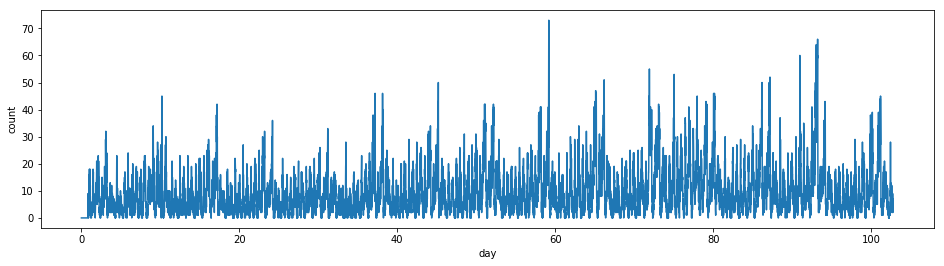

In [4]:
plt.figure(figsize=(16,4))
plt.plot(bin_edges[:-1]/(24*60*60), hist)
plt.xlabel('day')
plt.ylabel('count')
plt.show()

Amplify the graph and look at the data of second week. The maximum is at day 10 (1970-1-10), which is a Saturday. Within 1 day, there are more logins at noon and midnight, although this trend is not quite clear on weekends.

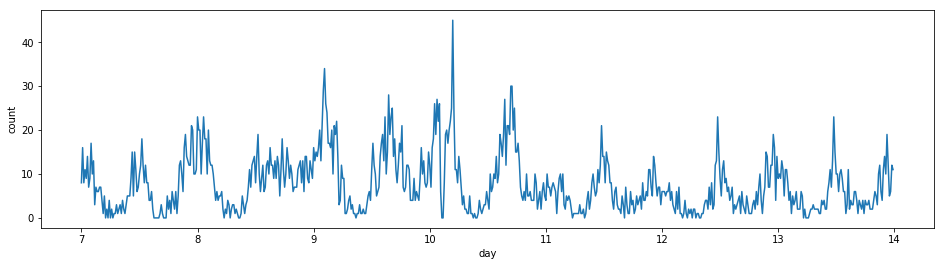

In [5]:
week = int(24*7*60/15)
plt.figure(figsize=(16,4))
plt.plot(bin_edges[week:week*2]/(24*60*60), hist[week:week*2])
plt.xlabel('day')
plt.ylabel('count')
plt.show()

To analysis the pattern of each week day, we can compute the average login count of each week day.

In [6]:
week_avg = np.zeros([week])
for i in range(14):
    week_avg += hist[week*i:week*(i+1)]
week_avg /= 14

day = int(24*60/15)
Thursday = week_avg[:day]
Friday = week_avg[day:2*day]
Saturday = week_avg[2*day:3*day]
Sunday = week_avg[3*day:4*day]
Monday = week_avg[4*day:5*day]
Tuesday = week_avg[5*day:6*day]
Wednesday = week_avg[6*day:7*day]

After ploting the average trend for each week day, we can now clearly see that the pattern is different in weekends and weekdays. In the weekends, there are a lot more logins in the early morning. Seems like people are staying up late to use the product.

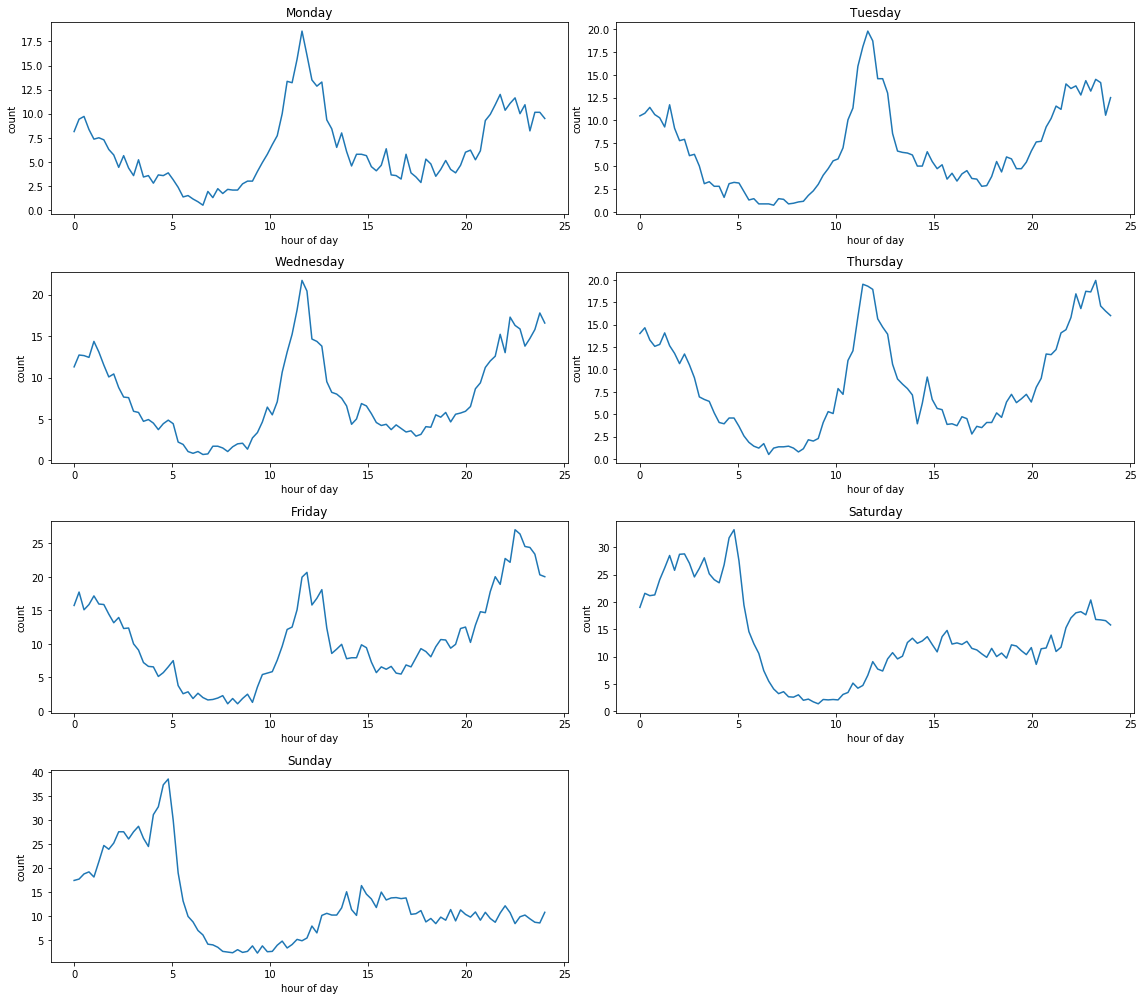

In [7]:
titles = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
hists = [Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday]
hours = np.linspace(0,24,96)

plt.figure(figsize=(16,14))

for i, hist in enumerate(hists):
    plt.subplot(4, 2, i+1)
    plt.xlabel("hour of day")
    plt.ylabel("count")
    plt.title(titles[i])
    plt.plot(hours, hist)
plt.tight_layout()
plt.show()

# Part 2

#### Metric
We can measure the ratio of drivers been in two cities with in one day. If the solution we are proposing is effective, we should see a larger proportion of drivers are willing to travel between two cities.

#### Experiment
a. We can divide all drivers available for experiment to two groups. One group we offer reimbursement of toll cost, the other we do not. For each day, we record how many drivers in each group were present in both cities and how many were stayed in just one city. We can test for a few days and average the results by day. We will end up with a table like this:

| Group | # of drivers travel to both cities| # of drivers stayed in one city|
|---|---|---|
| with reimbursement|         A1 | A2 |
| without reimbursement |     B1 | B2 |

b. We can use z-test for proportions to test the effectiveness of the solution. 

$H_0$: Offering reimbursement would not change drivers' willingness to travel to both cities.

$H_A$: Offering reimbursement would make drivers more likely to be present in two cities.

c. If there is a statistical significance, we may conclude that reimburse the tolls is a good way to encourage drivers to serve both cities. If not we may think of some other reasons that causing drivers to be reluctant to travel to another city, for example, the toll causes too much traffic.

A caveats in this study could be the duration of the test time. If we test for a short time, the result may not be stable. Also, there might be a "new change effect": the reimbursement is an incentive in a short term, but over the long term the it may loss effect if there are other reasons for the drivers to prefer staying in one city. If we test for too long, the two group of drivers may interact -- they may know other drivers are offered reimbursement or not and thus affect their behavior. And of course, testing too long may be expensive.

# Part 3

### Exploratory Data Analysis

#### Read data and construct dataframe

In [8]:
with open("ultimate_data_challenge.json") as json_data:
    data = json.load(json_data)

df = pd.DataFrame(data)
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


We are not told when the data is pulled, so we will assume it is the most recent trip date of all users, which is July 1, 2014. Then we can define users whose most recent trip is after June 1, 2014 to be retained user. There are 18310 retained users, which is 36.62% of all users.

current date 2014-07-01
False    31690
True     18310
Name: target, dtype: int64
fraction of retained user: 0.3662


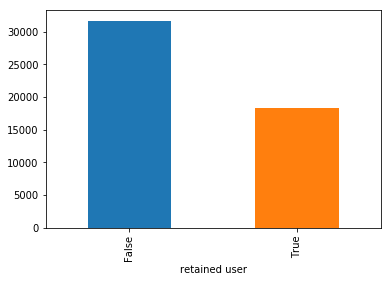

In [9]:
print("current date", df['last_trip_date'].max())
cutoff_date = '2014-06-01'
df['target'] = df['last_trip_date'] > cutoff_date
retained_count = df['target'].value_counts()
print(retained_count)
print("fraction of retained user:", retained_count[True]/df['target'].shape[0])
retained_count.plot.bar()
plt.xlabel("retained user")
plt.show()

#### Check for missing values
There are missing values on users' rating and devices. For ratings, we will create a categorical variable indicating whether the rating is missing and replace missing values with the global average. For device, we will replace NaN with "unknown" as a separate category.

In [10]:
df.isnull().sum()

avg_dist                     0
avg_rating_by_driver       201
avg_rating_of_driver      8122
avg_surge                    0
city                         0
last_trip_date               0
phone                      396
signup_date                  0
surge_pct                    0
trips_in_first_30_days       0
ultimate_black_user          0
weekday_pct                  0
target                       0
dtype: int64

In [11]:
df['missing_rating_by_driver'] = df['avg_rating_by_driver'].isnull()
df['missing_rating_of_driver'] = df['avg_rating_of_driver'].isnull()
df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(), inplace=True)
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean(), inplace=True)
df['phone'].fillna('unknown', inplace=True)

#### Explore the relation between some categorical variables and target ("retained user")

For categorical variables, we can compute the average percentage of retained user within each group. It more or less tells us if there is significant correlation between a certain categorical variable and the target.

* people with missing ratings (either ratings from drivers or their rating to drivers) are less likely to be retained user.

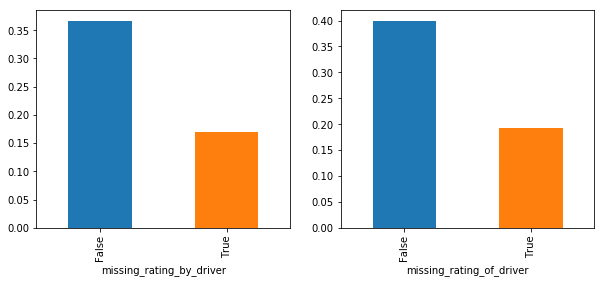

In [12]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
df.groupby('missing_rating_by_driver')['target'].mean().plot.bar()
plt.subplot(1,2,2)
df.groupby('missing_rating_of_driver')['target'].mean().plot.bar()
plt.show()

* iphone users are more likely to be retained than Android users. Users with unknown devices are in between.

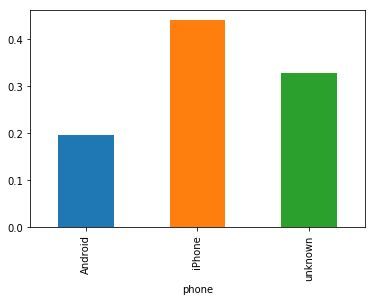

In [13]:
df.groupby('phone')['target'].mean().plot.bar()
plt.show()

* People in King's Landing is most likely retained, followed by people in Winterfell.

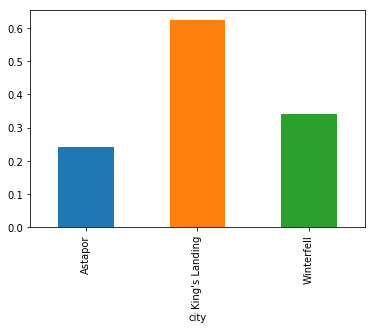

In [14]:
df.groupby('city')['target'].mean().plot.bar()
plt.show()

* The ultimate black users are more likely to be retained. This is not superising, as the black user seems to be some sort of membership which active users are more likely to have.

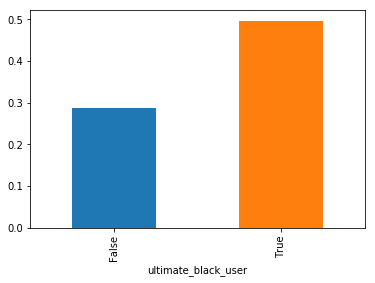

In [15]:
df.groupby('ultimate_black_user')['target'].mean().plot.bar()
plt.show()

#### Numerical Variables

For numerical variables, we compute their pearson correlation coefficient with the target. We identify two variables that are possitively correlated with retained user: surge percentage and weekday percentage.

In [16]:
num_variables = ['avg_dist','avg_rating_by_driver','avg_rating_of_driver','trips_in_first_30_days',
                'avg_surge','surge_pct','weekday_pct']

for col in num_variables:
    print(col, df[col].corr(df['target']))

avg_dist -0.09027878047559734
avg_rating_by_driver -0.025594799494099985
avg_rating_of_driver -0.01008185873465266
trips_in_first_30_days 0.21472789849785687
avg_surge -0.0035673057509046572
surge_pct 0.01061155307283674
weekday_pct 0.02641321338426598


## Predictive Model

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

#### One-hot encode categorical features (with more than two values).

In [18]:
city_enc = pd.get_dummies(df['city'])
phone_enc = pd.get_dummies(df['phone'])
df = pd.concat([df, city_enc, phone_enc], axis=1)

#### Normalize numerical features
This would not affect random forest but would be good for logistic regression.

In [19]:
for col in num_variables:
    df[col] = (df[col]-df[col].mean())/(df[col].max()-df[col].min())

In [20]:
features = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver',
       'avg_surge', 'surge_pct', 'trips_in_first_30_days', 'ultimate_black_user',
       'weekday_pct', 'missing_rating_by_driver',
       'missing_rating_of_driver', 'Astapor', "King's Landing",
       'Winterfell', 'Android', 'iPhone', 'unknown']

In [21]:
X, y = df[features], df['target']
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2)

#### Linear Regression

In [22]:
model = LogisticRegression()
model.fit(train_X, train_y)
train_pred = model.predict(train_X)
test_pred = model.predict(test_X)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [23]:
train_acc = accuracy_score(train_pred, train_y)
test_acc = accuracy_score(test_pred, test_y)
print("train accuracy:",train_acc, "test accuracy:", test_acc)

train_f1 = f1_score(train_pred, train_y)
test_f1 = f1_score(test_pred, test_y)
print("train F1:",train_f1, "test F1:", test_f1)

confmat = confusion_matrix(test_pred, test_y)
print("confusion matrix")
print(confmat)

train accuracy: 0.7285 test accuracy: 0.7293
train F1: 0.5738502589860304 test F1: 0.5765681213827624
confusion matrix
[[5450 1855]
 [ 852 1843]]


#### identify important predictors through model coefficients

In [24]:
feature_coef = pd.Series(model.coef_[0], index=features)
feature_coef.sort_values(ascending=False)

trips_in_first_30_days      11.351057
ultimate_black_user          0.886696
King's Landing               0.803343
iPhone                       0.367163
surge_pct                    0.320162
weekday_pct                  0.072517
unknown                     -0.183147
avg_rating_of_driver        -0.226442
Winterfell                  -0.414611
avg_rating_by_driver        -0.724409
missing_rating_of_driver    -0.737156
avg_surge                   -0.743648
Android                     -0.753879
missing_rating_by_driver    -0.828956
Astapor                     -0.958596
avg_dist                    -4.526987
dtype: float64

#### Random Forest

In [25]:
model = RandomForestClassifier(max_depth=6)
model.fit(train_X, train_y)
train_pred = model.predict(train_X)
test_pred = model.predict(test_X)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [26]:
train_acc = accuracy_score(train_pred, train_y)
test_acc = accuracy_score(test_pred, test_y)
print("train accuracy:",train_acc, "test accuracy:", test_acc)

train_f1 = f1_score(train_pred, train_y)
test_f1 = f1_score(test_pred, test_y)
print("train F1:",train_f1, "test F1:", test_f1)

confmat = confusion_matrix(test_pred, test_y)
print("confusion matrix")
print(confmat)

train accuracy: 0.77715 test accuracy: 0.7691
train F1: 0.6488339111251182 test F1: 0.6448238732502692
confusion matrix
[[5595 1602]
 [ 707 2096]]


#### identify important predictors through feature importance

In [27]:
feature_importance = pd.Series(model.feature_importances_, index=features)
feature_importance.sort_values(ascending=False)

avg_rating_by_driver        0.209251
avg_surge                   0.148014
King's Landing              0.139249
surge_pct                   0.128138
Android                     0.082941
trips_in_first_30_days      0.056315
Astapor                     0.056087
weekday_pct                 0.053365
ultimate_black_user         0.044308
iPhone                      0.041007
avg_rating_of_driver        0.016751
Winterfell                  0.011401
avg_dist                    0.008639
missing_rating_of_driver    0.003609
missing_rating_by_driver    0.000831
unknown                     0.000095
dtype: float64

Logistic Regression provides a good baseline for this problem, and random forest model improves both accuracy and F1 score. Both models' perfermance are similar on training and test set, which means the models are able to generalize. Users' city seem to be a strong factor, this may indicate the service provided in different city have different qualities. Likewise, people using Android are less likely to be retained than people using iphone, ultimate company can look into this, and figure out is this related to app performance on different platforms. Surperisingly, users give higher rating to drivers or recieve higher rating are actually less active. It is worthwhile to figure out the reason behind this.